In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [15,8]

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Phase - II Implementation/Sales/Alcohol Sales Analysis/Alcohol_Sales_Data.csv')
df.head()

,DATE,Millions of Dollars
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221


In [6]:
df.tail()

,DATE,Millions of Dollars
352,2021-05-01,15499
353,2021-06-01,17830
354,2021-07-01,15742
355,2021-08-01,16142
356,2021-09-01,15772


In [7]:
df.shape

(357, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   DATE                 357 non-null    object
 1   Millions of Dollars  357 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.7+ KB


In [9]:
df.isnull().sum()

DATE                   0
Millions of Dollars    0
dtype: int64

In [10]:
time = pd.date_range(start='1/1/1992',end='09/30/2021',freq='M')
time

DatetimeIndex(['1992-01-31', '1992-02-29', '1992-03-31', '1992-04-30',
               '1992-05-31', '1992-06-30', '1992-07-31', '1992-08-31',
               '1992-09-30', '1992-10-31',
               ...
               '2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31',
               '2021-04-30', '2021-05-31', '2021-06-30', '2021-07-31',
               '2021-08-31', '2021-09-30'],
              dtype='datetime64[ns]', length=357, freq='M')

In [11]:
len(time)

357

In [12]:
df['time_stamp'] = pd.DataFrame(time)

In [13]:
df.head()

,DATE,Millions of Dollars,time_stamp
0,1992-01-01,3459,1992-01-31
1,1992-02-01,3458,1992-02-29
2,1992-03-01,4002,1992-03-31
3,1992-04-01,4564,1992-04-30
4,1992-05-01,4221,1992-05-31


In [14]:
df.tail()

,DATE,Millions of Dollars,time_stamp
352,2021-05-01,15499,2021-05-31
353,2021-06-01,17830,2021-06-30
354,2021-07-01,15742,2021-07-31
355,2021-08-01,16142,2021-08-31
356,2021-09-01,15772,2021-09-30


In [15]:
df.drop('DATE',axis=1,inplace=True)
df = df.set_index('time_stamp')

In [21]:
df.columns = ['Millions_of_Dollars']

In [22]:
df.head()

,Millions_of_Dollars
time_stamp,
1992-01-31,3459
1992-02-29,3458
1992-03-31,4002
1992-04-30,4564
1992-05-31,4221


In [23]:
df.tail()

,Millions_of_Dollars
time_stamp,
2021-05-31,15499
2021-06-30,17830
2021-07-31,15742
2021-08-31,16142
2021-09-30,15772


In [24]:
plt.rcParams['figure.figsize'] = [15,8]

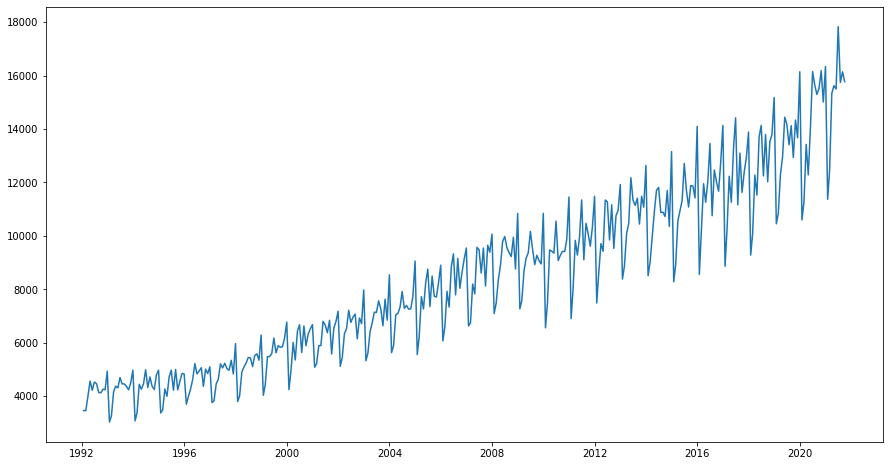

In [25]:
plt.plot(df)
plt.show()

In [26]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [28]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['Millions_of_Dollars'] = df['Millions_of_Dollars'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [29]:
#Split data set into testing dataset and train dataset
train_size = 310
train, test =df_arr[0:train_size,:],df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 12
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

In [30]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(298, 12)
(298,)
(35, 12)
(35,)


In [31]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 5.2 MB/s 


In [32]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [33]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 1, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value = 512,
                                            step=8),
                                            activation= "relu"))
        if hp.Boolean("dropout"):
          model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.4,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [34]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=20,
    executions_per_trial=1,
    directory='project',
    project_name='alcohol_1')

In [35]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 512, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [36]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=34,
             validation_data=(testX, testY))

Trial 20 Complete [00h 00m 19s]
val_mape: 24.530059814453125

Best val_mape So Far: 3.9551923274993896
Total elapsed time: 00h 10m 03s
INFO:tensorflow:Oracle triggered exit


In [37]:
tuner.results_summary()

Results summary
Results in project/alcohol_1
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 18
units_0: 288
dropout: False
learning_rate: 0.0007801737247177319
Dropout_rate: 0.4
units_1: 72
units_2: 304
units_3: 424
units_4: 176
units_5: 440
units_6: 128
units_7: 512
units_8: 344
units_9: 32
units_10: 192
units_11: 96
units_12: 376
units_13: 368
units_14: 184
units_15: 88
units_16: 80
units_17: 144
units_18: 264
Score: 3.9551923274993896
Trial summary
Hyperparameters:
num_layers: 19
units_0: 272
dropout: False
learning_rate: 0.0013527656372130021
Dropout_rate: 0.4
units_1: 96
units_2: 456
units_3: 408
units_4: 200
units_5: 312
units_6: 496
units_7: 504
units_8: 464
units_9: 16
units_10: 328
units_11: 400
units_12: 280
units_13: 168
units_14: 152
units_15: 8
units_16: 8
units_17: 8
units_18: 8
Score: 4.157166957855225
Trial summary
Hyperparameters:
num_layers: 13
units_0: 440
dropout: False
learning_rate: 0.0001554165085798412
Dropout_rate: 0.0
units_1: 16
units_2: 96

In [38]:
models = tuner.get_best_models(num_models=1)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 12))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 288)               3744      
                                                                 
 dense_1 (Dense)             (None, 72)                20808     
                                                                 
 dense_2 (Dense)             (None, 304)               22192     
                                                                 
 dense_3 (Dense)             (None, 424)               129320    
                                                                 
 dense_4 (Dense)             (None, 176)               74800     
                                                                 
 dense_5 (Dense)             (None, 440)               77880     
                                                                 
 dense_6 (Dense)             (None, 128)               5

In [39]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [41]:
model = Sequential()
model.add(Dense(288,activation='relu',input_dim = 12))
model.add(Dense(72,activation='relu'))
model.add(Dense(304,activation='relu'))
model.add(Dense(424,activation='relu'))
model.add(Dense(176,activation='relu'))
model.add(Dense(440,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(344,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(192,activation='relu'))
model.add(Dense(96,activation='relu'))
model.add(Dense(376,activation='relu'))
model.add(Dense(368,activation='relu'))
model.add(Dense(184,activation='relu'))
model.add(Dense(88,activation='relu'))
model.add(Dense(80,activation='relu'))
model.add(Dense(144,activation='relu'))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate = 0.000007801737247177319)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 34, epochs = 500)

Epoch 1/500
9/9 [==============================] - 2s 42ms/step - loss: 99.8218 - mape: 99.8218 - val_loss: 99.8111 - val_mape: 99.8111
Epoch 2/500
9/9 [==============================] - 0s 16ms/step - loss: 99.4155 - mape: 99.4155 - val_loss: 99.6255 - val_mape: 99.6255
Epoch 3/500
9/9 [==============================] - 0s 17ms/step - loss: 98.9889 - mape: 98.9889 - val_loss: 99.4239 - val_mape: 99.4239
Epoch 4/500
9/9 [==============================] - 0s 18ms/step - loss: 98.5106 - mape: 98.5106 - val_loss: 99.2014 - val_mape: 99.2014
Epoch 5/500
9/9 [==============================] - 0s 17ms/step - loss: 98.0016 - mape: 98.0016 - val_loss: 98.9524 - val_mape: 98.9524
Epoch 6/500
9/9 [==============================] - 0s 18ms/step - loss: 97.4468 - mape: 97.4468 - val_loss: 98.6662 - val_mape: 98.6662
Epoch 7/500
9/9 [==============================] - 0s 17ms/step - loss: 96.8177 - mape: 96.8177 - val_loss: 98.3314 - val_mape: 98.3314
Epoch 8/500
9/9 [==============================]

In [42]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [43]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 3.92 
Test MAPE : 4.44 


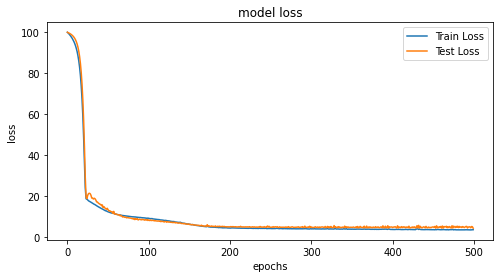

In [44]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [46]:
import seaborn as sns

In [47]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(298,333)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

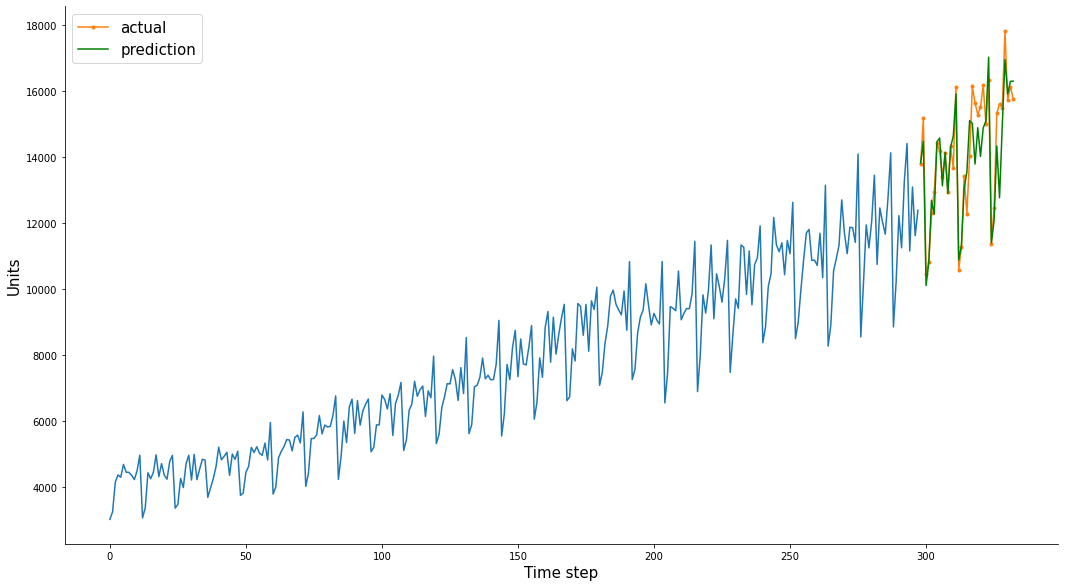

In [48]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)